# 文本分类-20 newsgroups

In [1]:
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import numpy as np

# 从20个分类中挑选4个进行训练
categories = ['talk.politics.guns', 'rec.motorcycles', 'comp.graphics', 'sci.space']

# 数据探索

探索每个分类的数据分布情况

In [9]:
category_numbers = []
for category in categories:
    numbers = len(fetch_20newsgroups(subset='train', categories=[category]).target)
    category_numbers.append(numbers)
print (category_numbers)

[546, 598, 584, 593]


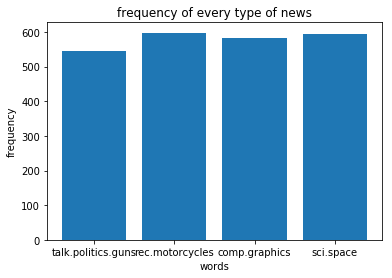

In [10]:
plt.bar(range(len(categories)) ,category_numbers)
plt.xlabel('words')
plt.ylabel('frequency')
plt.xticks(range(len(categories)),categories)
plt.title('frequency of every type of news')
plt.show()

In [11]:
# 文本内容例子
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_train.data[1]

'Subject: Re: Shaft-drives and Wheelies\nFrom: Stafford@Vax2.Winona.MSUS.Edu (John Stafford)\nDistribution: world\nOrganization: Winona State University\nNntp-Posting-Host: stafford.winona.msus.edu\nLines: 19\n\nIn article <1r16ja$dpa@news.ysu.edu>, ak296@yfn.ysu.edu (John R. Daker)\nwrote:\n> \n> \n> In a previous article, xlyx@vax5.cit.cornell.edu () says:\n> \n> Mike Terry asks:\n> \n> >Is it possible to do a "wheelie" on a motorcycle with shaft-drive?\n> >\n> No Mike.  It is imposible due to the shaft effect.  The centripital effects\n> of the rotating shaft counteract any tendency for the front wheel to lift\n> off the ground.\n\n\tThis is true as evinced by the popularity of shaft-drive drag bikes.\n\n====================================================\nJohn Stafford   Minnesota State University @ Winona\n                    All standard disclaimers apply.\n'

In [12]:
# 将data list中的文本去掉符号并合成一个，为了统计单词频率
import re
# 文本单词集合
words_collect = []
# 每一篇文本长度的集合
news_length = []
for i in range(len(newsgroups_train.data)):
    #s = re.sub(r'[^\w\s]','',newsgroups_train.data[i]).split(' ')
    news = newsgroups_train.data[i]
    news_words = news.split(' ')
    news_length.append(len(news_words))
    words_collect.extend(news_words)
print('max news length:', max(news_length))
print('min news length:', min(news_length))

max news length: 9555
min news length: 11


每篇文档的单词数量分布情况

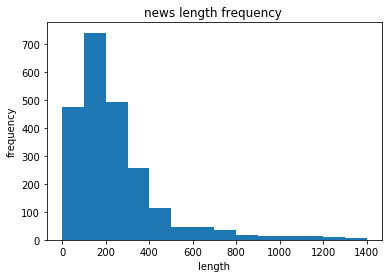

In [13]:
plt.hist(news_length, bins =  range(0, 1500, 100))
plt.xlabel('length')
plt.ylabel('frequency')
plt.title('news length frequency ') 
plt.show()

文档中单词频率最高的9个词

In [14]:
from collections import Counter
c = Counter(words_collect)
# 计算次数最多的前10个
most_common = c.most_common(10) 
print (most_common)

[('', 123483), ('the', 21759), ('to', 12076), ('of', 11983), ('a', 11183), ('and', 9173), ('in', 6582), ('is', 6404), ('I', 5633), ('that', 5173)]


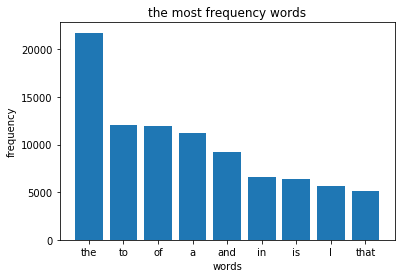

In [15]:
x_word = []
x_time = range(0,9)
y_num = []
# 忽略空符号，所以从1开始算
for item in most_common[1:]:
    x_word.append(item[0])
    y_num.append(item[1])

plt.bar(x_time ,y_num)
plt.xlabel('words')
plt.ylabel('frequency')
plt.xticks(x_time,x_word)
plt.title('the most frequency words')
plt.show()

可以看出数据中大部分都是没有携带信息的常规单词如定冠词the,介词of等，这对于建立模型并没有好处，因此我们需要提取重要信息的单词。可以使用TF-IDF方法

# 一：TF-IDF
使用TF-IDF方法表征一篇文档

这个函数用于去掉文本中的符号等信息,并转化为小写

In [16]:
import re
def preprocessor(text):
    text = re.sub('[\W]+', ' ', text.lower()) 
    return text

文本中的单词不适合做特征，所以需要转化。下面我使用TF-IDF的方法进行表征。

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer(preprocessor=preprocessor, stop_words='english', min_df=0.001)
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
X_train = vectorizer.fit_transform(newsgroups_train.data)

newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
X_test = vectorizer.transform(newsgroups_test.data) 

In [11]:
print(X_train.shape)

(2321, 13315)


## 算法：MultinomialNB

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import ShuffleSplit

nb = MultinomialNB()
# 通过grid search 探索alpha参数的最佳值
parameters = {'alpha':[round(0.005*x, 3) for x in range(1, 300, 10)]}
cv_sets = ShuffleSplit(X_train.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
scoring_fnc = make_scorer(accuracy_score)
clf = GridSearchCV(nb, parameters, cv=cv_sets)
clf.fit(X_train, newsgroups_train.target)
# 得到最佳的模型数据
best_clf = clf.best_estimator_
print('best estimator: ', best_clf)
pred = best_clf.predict(X_test)
accuracy_score(newsgroups_test.target, pred)

best estimator:  MultinomialNB(alpha=0.055, class_prior=None, fit_prior=True)


0.96245954692556634

# 二：词向量
使用词向量表征文档

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Dropout
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import EarlyStopping

newsgroups = fetch_20newsgroups(subset='all', categories=categories)
target = newsgroups.target
# 文本序列长度
MAX_SEQUENCE_LENGTH = 300
# 单词数量
MAX_NB_WORDS = 10000
# 词向量长度
EMBEDDING_DIM = 100

Using TensorFlow backend.


In [3]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(newsgroups.data)
sequences = tokenizer.texts_to_sequences(newsgroups.data)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# 将数据分为train/test集
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=42)

# one-hot 标签
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

Found 49363 unique tokens.


## 算法-CNN

In [ ]:
# 通过early_stop在精度不再提高的时候停止
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=0)

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,  dropout=0.5)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(32, 5, activation='relu', W_regularizer=l2(0.01) )(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
preds = Dense(4, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

his = model.fit(X_train, y_train, 
                        nb_epoch=150, 
                        batch_size=32, 
                        validation_split=0.2,
                        callbacks=[early_stop])

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1855 samples, validate on 464 samples
Epoch 1/150
1855/1855 [==============================] - 1s - loss: 1.3768 - acc: 0.3105 - val_loss: 1.3576 - val_acc: 0.3017

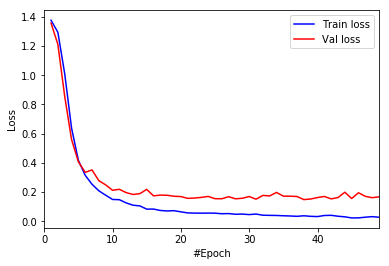

the accuracy of 20news by cnn is 0.9825468649


In [7]:
# 可视化输出
score = model.evaluate(X_test, y_test, verbose=0)

train_loss = his.history['loss']
val_loss = his.history['val_loss']

plt.plot(range(1, len(train_loss)+1), train_loss, color='blue', label='Train loss')
plt.plot(range(1, len(val_loss)+1), val_loss, color='red', label='Val loss')
plt.xlim(0, len(train_loss))
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.savefig('fig-nn-val-earlystop.png', dpi=300)
plt.show()
# 打印测试精度
print('the accuracy of 20news by cnn is %s' % score[1])

# 总结

### 模型稳建性

1.MultinomialNB- 不同alpha的模型表现

| alpha | 0.001 | 0.01 | 0.1 |  1  | 2   |
| ------| ------ | ------ |-----|---|---|--|
| 测试精度| 0.9553 | 0.9608 |0.9618| 0.9644|0.9637|

2.CNN-不同迭代次数的表现

| 迭代次数 | 1 | 10 | 20 |  30  | 49   |
| ------ | ------ | ------ |-----|---|---|--|
| 训练精度| 0.3224 | 0.9752 |0.9876| 0.9938|0.0.9941 |
| 测试精度| 0.3684 |  0.9567 |0.9676|0.9812| 0.982|

### 模型结果的表现

接下来看看其中MultinomialNB给出的一个结果，对于主题重要意义的单词（权重大的）

In [35]:
import bottleneck as bn
weight_NB = best_clf.coef_[3]
# 权重最大的10个值
most_largest_weight_index = bn.argpartition(-weight_NB, 10)[:10] 
# 权重最大的10个值对应的单词
most_largest_words = []
words_dic = vectorizer.vocabulary_ 
for index in most_largest_weight_index:
    for key, value in words_dic.items():
        if value == index:
            most_largest_words.append(key)

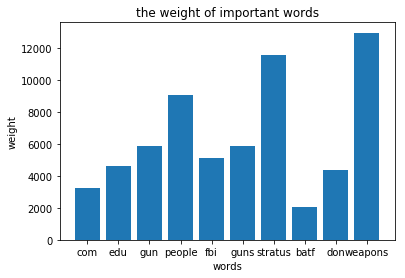

In [36]:
plt.bar(range(len(most_largest_weight_index)) ,most_largest_weight_index)
plt.xlabel('words')
plt.ylabel('weight')
plt.xticks(range(len(most_largest_weight_index)),most_largest_words)
plt.title('the weights of important words')
plt.show()

从上图可以看出，MultinomialNB模型成功抓住了'talk.politics.guns'主题一些关键词如'weapons'（武器），gun(枪)，(fbi)美国联邦调查局等

### 后续提升考虑

从上面的重要单词的权重可以看出，文本处理的时候没有考虑到单复数，也没有去掉一些干扰词如'com'，在这方面可以提升。

### 结束语

这个项目的目标是进行文档分类，我在朴素贝叶斯方法中使用TF-IDF得到了0.96左右的精度。通过卷积神经网络在中使用词向量得到了0.98左右的精度。这都高于了基准模型0.88，模型表现还不错，当然也有很多可以提升的地方。